In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
import warnings
#!pip install scikit-optimize
from skopt import gp_minimize
from skopt.space import Categorical, Real, Integer

%run "C:\Users\tomas/Downloads\OA_project_20221894\base\dataset_generation.ipynb"
%run "C:\Users\tomas\Downloads\OA_project_20221894\base\individual.ipynb"
%run "C:\Users\tomas\Downloads\OA_project_20221894\base\population.ipynb"
%run "C:\Users\tomas\Downloads\OA_project_20221894\operators_utils\selection_algorithms.ipynb"
%run "C:\Users\tomas\Downloads\OA_project_20221894\operators_utils\crossovers.ipynb"
%run "C:\Users\tomas\Downloads\OA_project_20221894\operators_utils\mutators.ipynb"
%run "C:\Users\tomas\Downloads\OA_project_20221894\operators_utils\utils.ipynb"
%run "C:\Users\tomas\Downloads\OA_project_20221894\algorithm\algorithm.ipynb"

## Parameter Search

In [29]:
# Our geo matrices
matrix1 = generate_matrix(seed=1, lower_bound=-9, higher_bound=11)
matrix2 = generate_matrix(seed=2, lower_bound=-30, higher_bound=70)
matrix3 = generate_matrix(seed=3, lower_bound=-10, higher_bound=90)
matrix4 = generate_matrix(seed=4, lower_bound=-98, higher_bound=102)
matrix5 = generate_matrix(seed=5, lower_bound=-300, higher_bound=700)
matrix6 = generate_matrix(seed=6, lower_bound=-100, higher_bound=900)
matrix7 = generate_matrix(seed=7, lower_bound=-980, higher_bound=1020)
matrix8 = generate_matrix(seed=8, lower_bound=-3000, higher_bound=7000)
matrix9 = generate_matrix(seed=9, lower_bound=-1000, higher_bound=9000)
matrix10 = generate_matrix(seed=10, lower_bound=-9800, higher_bound=10200)
matrix11 = generate_matrix(seed=11, lower_bound=-30000, higher_bound=70000)
matrix12 = generate_matrix(seed=12, lower_bound=-10000, higher_bound=90000)
matrix13 = generate_matrix(seed=13, lower_bound=-98000, higher_bound=102000)
matrix14 = generate_matrix(seed=14, lower_bound=-300000, higher_bound=700000)
matrix15 = generate_matrix(seed=17, lower_bound=-100000, higher_bound=900000)
matrix16 = generate_matrix(seed=18, lower_bound=-980000, higher_bound=1020000)
matrix17 = generate_matrix(seed=19, lower_bound=-3000000, higher_bound=7000000)
matrix18 = generate_matrix(seed=20, lower_bound=-1000000, higher_bound=9000000)
matrix = [matrix1, matrix2, matrix3, matrix4, matrix5, matrix6, matrix7, matrix8, matrix9,
          matrix10, matrix11, matrix12, matrix13, matrix14, matrix15, matrix16, matrix17, matrix18]

In [14]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="The objective has been evaluated at point", category=UserWarning)

# Defining the parameter mapping
param_mapping = {
    "selector": [roulette_wheel, ranking_selection, tournament_selection(2), tournament_selection(5), tournament_selection(10)],
    "crossover": [cyclic_xover, pmx_xover, ordered_xover, two_point_xover],
    "mutator": [swap_mutation, inversion_mutation, mix_mutation, disp_mutation, two_point_mutation],
    "elitism": [True, False] }

# Also defining an wrapper function of our algorithm, to be able to input it into the Bayesian Optimization
def genetic_algorithm_wrapper(matrix, selector, crossover, mutator, pop_size, n_gens, p_xo, p_m, elitism, n_elites):
    """
    A wrapper function for running a genetic algorithm with specified parameters.

    This function initializes the population, evaluates it, and iterates over a number of generations
    to evolve solutions based on selection, crossover, mutation, and elitism strategies.

    Args:
        The same as the GA() function.

    Returns:
        float: The negation of the fitness of the best individual in the final population,
               suitable for use with optimization algorithms that minimize the objective.
    """

    initializer = create_population
    evaluator = evaluate_pop
    elite_func = get_n_elites(n_elites)

    selector = param_mapping["selector"][selector]
    crossover = param_mapping["crossover"][crossover]
    mutator = param_mapping["mutator"][mutator]
    elitism = param_mapping["elitism"][elitism]

    # Call GA function with the parameters defining above
    _, pop_fit = GA(matrix, initializer, evaluator, selector, crossover, mutator, elite_func,
                    pop_size, n_gens, p_xo, p_m, elitism=elitism)

    # Returning the negation of our best individual, since gp_minimize works assumes this is a minimization problem
    return -max(pop_fit)

# Defining the search space for Bayesian optimization
space = [
    Categorical(list(range(len(param_mapping["selector"]))), name='selector'),
    Categorical(list(range(len(param_mapping["crossover"]))), name='crossover'),
    Categorical(list(range(len(param_mapping["mutator"]))), name='mutator'),
    Categorical(categories=[25, 50, 100], name='pop_size'),
    Categorical(categories=[250, 500, 750], name='n_gens'),
    Categorical(categories=[0.2, 0.4, 0.6, 0.8], name='p_xo'),
    Categorical(categories=[0.2, 0.4, 0.6, 0.8], name='p_m'),
    Categorical(categories=[True, False], name='elitism'),
    Categorical(categories=[2, 3, 4, 5], name='n_elites'),
]

# Defining a dict to store our results
results = {}

# Iterating over every matrix
for i, mat in enumerate([matrix1, matrix2, matrix3, matrix4, matrix5, matrix6, matrix7, matrix8, matrix9, matrix10, matrix11, matrix12, matrix13, matrix14, matrix15, matrix16, matrix17, matrix18]):
    # Defining a dict to store the results of each matrix
    results_mat = []
    # Performing the parameter search 10 times, for each matrix
    for _ in trange(10):

        result = gp_minimize(
            lambda params: genetic_algorithm_wrapper(mat, *params),  # our objective function that will be minimized
            space,                      # our search space
            n_calls=15,                 # the number of evaluations of the objective function
            random_state=24,            # random seed for reproducibility
        )

        # Getting our results  in a more pretty way
        res = [param_mapping[par][result.x[i]].__name__ + (str(param_mapping[par][result.x[i]].ts_value) if 'tournament' in str(param_mapping[par][result.x[i]]) else '')
               for i, par in enumerate(['selector', 'crossover', 'mutator']) ]

        res.extend(result.x[3:])
        print(res, -result.fun)

        results_mat.append([res, -result.fun])   # Negating again our results, to cancel the negation on the wrapper function
    print(f"{i+1}")

    results[f'Matrix{i+1}'] = results_mat

 10%|█         | 1/10 [01:04<09:39, 64.44s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 87


 10%|█         | 1/10 [01:10<10:30, 70.09s/it]


KeyboardInterrupt: 

The cell below has the results of our parameter search, so you don't need to run it all over again

In [15]:
# Our Bayesian Optimization results
results = {'Matrix1': [[['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   87],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   87],
  [['roulette_wheel',
    'pmx_xover',
    'mix_mutation',
    25,
    750,
    0.2,
    0.8,
    False,
    3],
   87],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   87],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   87],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   87],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   87],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   87],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   87],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   87]],
 'Matrix2': [[['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    750,
    0.8,
    0.2,
    False,
    2],
   533],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   533],
  [['tournament_sec5',
    'two_point_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.4,
    False,
    2],
   533],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   533],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   533],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   533],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   533],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   533],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   533],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   533]],
 'Matrix3': [[['tournament_sec5',
    'two_point_xover',
    'inversion_mutation',
    100,
    750,
    0.6,
    0.6,
    False,
    2],
   763],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   763],
  [['ranking_selection',
    'cyclic_xover',
    'swap_mutation',
    100,
    500,
    0.6,
    0.2,
    False,
    4],
   763],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   763],
  [['tournament_sec2',
    'two_point_xover',
    'inversion_mutation',
    50,
    250,
    0.6,
    0.2,
    False,
    2],
   763],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   763],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   763],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   763],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   763],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   763]],
 'Matrix4': [[['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   763],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    250,
    0.4,
    0.4,
    False,
    5],
   763],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   763],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   759],
  [['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   763],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   763],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   763],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   763],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   759],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   763]],
 'Matrix5': [[['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   5783],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   5783],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   5783],
  [['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   5783],
  [['ranking_selection',
    'pmx_xover',
    'disp_mutation',
    50,
    250,
    0.4,
    0.4,
    False,
    5],
   5783],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   5783],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   5783],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   5783],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   5685],
  [['tournament_sec5',
    'two_point_xover',
    'disp_mutation',
    25,
    750,
    0.6,
    0.4,
    False,
    4],
   5783]],
 'Matrix6': [[['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   7369],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7369],
  [['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   7369],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   7369],
  [['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   7369],
  [['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   7369],
  [['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   7369],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   7369],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7369],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    50,
    250,
    0.2,
    0.4,
    False,
    3],
   7369]],
 'Matrix7': [[['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7959],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7959],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   7959],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7959],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7959],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7959],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   7959],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7959],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   7959],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7959]],
 'Matrix8': [[['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   46869],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   46869],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   46869],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   46869],
  [['tournament_sec5',
    'cyclic_xover',
    'swap_mutation',
    50,
    750,
    0.6,
    0.2,
    False,
    3],
   46869],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   46869],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   46869],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   46869],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   46817],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   46869]],
 'Matrix9': [[['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   72044],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   72044],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   72044],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   72044],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   72044],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   72044],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   72044],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   72044],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   72044],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   72044]],
 'Matrix10': [[['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   62929],
  [['tournament_sec2',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.6,
    0.2,
    False,
    3],
   62929],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   62929],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   62929],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   62929],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   62929],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   62929],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   62929],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   62929],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   62899]],
 'Matrix11': [[['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   516715],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   516715],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   516715],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   516715],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   516715],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   516715],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   516715],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   516715],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   516715],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   516715]],
 'Matrix12': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   725468],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   725468],
  [['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   725468],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   725468],
  [['ranking_selection',
    'cyclic_xover',
    'disp_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   725468],
  [['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   725468],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   725468],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   725468],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   725468],
  [['tournament_sec5',
    'two_point_xover',
    'disp_mutation',
    50,
    750,
    0.2,
    0.4,
    False,
    3],
   725468]],
 'Matrix13': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   731619],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   731619],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   731619],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   731619],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   731619],
  [['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   731619],
  [['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   731619],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   731619],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   731619],
  [['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   731619]],
 'Matrix14': [[['tournament_sec2',
    'cyclic_xover',
    'mix_mutation',
    50,
    750,
    0.4,
    0.6,
    False,
    3],
   5076198],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.4,
    False,
    5],
   5076198],
  [['roulette_wheel',
    'pmx_xover',
    'mix_mutation',
    50,
    500,
    0.6,
    0.2,
    False,
    3],
   5076198],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   5076198],
  [['tournament_sec5',
    'two_point_xover',
    'disp_mutation',
    25,
    750,
    0.6,
    0.6,
    False,
    4],
   5076198],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    750,
    0.2,
    0.4,
    False,
    3],
   5076198],
  [['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   5076198],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   5076198],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   5076198],
  [['tournament_sec5',
    'two_point_xover',
    'disp_mutation',
    100,
    250,
    0.2,
    0.6,
    False,
    2],
   5076198]],
 'Matrix15': [[['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7280064],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   7280064],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7280064],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7280064],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7280064],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7280064],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   7280064],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   7280064],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7280064],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7280064]],
 'Matrix16': [[['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   7344888],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7344888],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   7344888],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   7344888],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   7344888],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7344888],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7344888],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7344888],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7344888],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7344888]],
 'Matrix17': [[['roulette_wheel',
    'cyclic_xover',
    'disp_mutation',
    50,
    500,
    0.6,
    0.2,
    False,
    5],
   52552794],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   52552794],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   52052398],
  [['tournament_sec2',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    2],
   52552794],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   52552794],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   52552794],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   52552794],
  [['tournament_sec5',
    'cyclic_xover',
    'swap_mutation',
    25,
    750,
    0.6,
    0.2,
    False,
    3],
   52552794],
  [['tournament_sec10',
    'cyclic_xover',
    'mix_mutation',
    50,
    750,
    0.6,
    0.2,
    False,
    3],
   52552794],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   52552794]],
 'Matrix18': [[['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   73352515],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   73352515],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   73352515],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   73352515],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   73352515],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   73352515],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   73352515],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   73352515],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   73352515],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   73352515]]}


Getting our results in a dataframe:

In [60]:
warnings.filterwarnings("ignore", message="indexing past lexsort depth may impact performance")

# This set will store all the parameter combinations that are unique
unique_param_combinations = set()

# Iterating over the parameter combinations
for mat in results.values():
    for parameters, _ in mat:
        param_tuple = tuple(parameters)
        # adding the unique combinations to the set
        unique_param_combinations.add(tuple(param_tuple))

# Creating the multiindex of our dataframe
index = pd.MultiIndex.from_tuples(unique_param_combinations, names=['Selector', 'Crossover', 'Mutator', 'Pop_Size', 'N_Gens', 'P_XO', 'P_M', 'Elitism', 'N_elites'])

df = pd.DataFrame(index=index)

# Iterating over the results
for matrix_name, mat in results.items():
    for parameters, fitness in mat:
        param_tuple = tuple(parameters)

        # If the current matrix is still not on the df
        if matrix_name not in df.columns:
            # We create it, and add there a list with the current fitness
            df[matrix_name] = None
            df.at[param_tuple, matrix_name] = [fitness]
        else:
            # If the column already exists, we check if there's already data at the current location
            if df.at[param_tuple, matrix_name] == None:
                # If there's no data, create a new list with the fitness value
                df.at[param_tuple, matrix_name] = [fitness]

            else:
                #iif there's data there, we append the fitness value to the list
                existing_data = df.at[param_tuple, matrix_name]
                existing_data.append(fitness)
                df.at[param_tuple, matrix_name] = existing_data

# After collecting all the fitnesses, we take the mean of the lists we created
for index, row in df.iterrows():
    for column in df.columns:
        value = df.at[index, column]
        # Checking if the value is a list
        if isinstance(value, list):
            df.at[index, column] = round(np.mean(value), 2)


df['Votes'] = df.count(axis=1)
df = df.loc[df['Votes']>1]
df.sort_values('Votes', ascending=False)

,,,,,,,,,Matrix1,Matrix2,Matrix3,Matrix4,Matrix5,Matrix6,Matrix7,Matrix8,Matrix9,Matrix10,Matrix11,Matrix12,Matrix13,Matrix14,Matrix15,Matrix16,Matrix17,Matrix18,Votes
Selector,Crossover,Mutator,Pop_Size,N_Gens,P_XO,P_M,Elitism,N_elites,,,,,,,,,,,,,,,,,,,
ranking_selection,cyclic_xover,inversion_mutation,100,500,0.8,0.4,False,3,87.0,533.0,763.0,762.2,5783.0,7369.0,7959.0,46869.0,72044.0,62919.0,516715.0,725468.0,731619.0,5076198.0,7280064.0,7344888.0,52552794.0,73352515.0,18
tournament_sec10,pmx_xover,inversion_mutation,50,500,0.4,0.4,False,5,87.0,533.0,None,761.0,5766.67,7369.0,7959.0,46856.0,72044.0,62929.0,516715.0,725468.0,731619.0,5076198.0,7280064.0,7344888.0,52302596.0,73352515.0,17
tournament_sec5,two_point_xover,swap_mutation,50,750,0.4,0.2,False,3,None,None,None,763.0,5783.0,7369.0,None,None,None,None,None,725468.0,731619.0,5076198.0,None,None,None,None,6
tournament_sec10,two_point_xover,swap_mutation,25,500,0.8,0.2,False,3,None,None,None,None,None,7369.0,None,None,None,62929.0,None,None,None,5076198.0,None,None,52552794.0,73352515.0,5
tournament_sec5,pmx_xover,inversion_mutation,50,750,0.4,0.2,False,3,None,None,None,763.0,None,None,None,46869.0,None,None,None,None,None,None,None,None,None,None,2


Getting the number of wins of each model (the number of times each model had the highest score on a matrix)

In [62]:
max_indices = pd.DataFrame(index=df.columns, columns=['Max_Indices'])

# Iterating over each column
for column in df.columns[:-1]:
    # Find the maximum value in the column
    max_val = df[column].max()
    # Find all indices where the maximum value occurs
    indices = df[df[column] == max_val].index.tolist()
    # Store the indices in the 'Max_Indices' column
    max_indices.at[column, 'Max_Indices'] = indices

# Getting the occurrences of each win, and transforming it into a variable
winners = dict(max_indices.explode('Max_Indices').value_counts())
winners = {key[0]:val for key, val in winners.items()}
df['Wins'] = winners
df['Wins'].fillna(0, inplace=True)
pd.DataFrame(df.loc[:, df.columns.isin(['Votes', 'Wins'])])

,,,,,,,,,Votes,Wins
Selector,Crossover,Mutator,Pop_Size,N_Gens,P_XO,P_M,Elitism,N_elites,,
tournament_sec10,pmx_xover,inversion_mutation,50,500,0.4,0.4,False,5,17,13
tournament_sec5,pmx_xover,inversion_mutation,50,750,0.4,0.2,False,3,2,2
tournament_sec10,two_point_xover,swap_mutation,25,500,0.8,0.2,False,3,5,5
tournament_sec5,two_point_xover,swap_mutation,50,750,0.4,0.2,False,3,6,6
ranking_selection,cyclic_xover,inversion_mutation,100,500,0.8,0.4,False,3,18,17


In [70]:
df = df.sort_values('Votes')

In [71]:
# Defining a dict with a name for each model
model_labels = {df.index[i]: f'Model{i+1}' for i in range(len(df))}

In [72]:
# Creating the net votes variable, that represents the number of votes that were not wins
data = pd.DataFrame(df.loc[:, df.columns.isin(['Votes', 'Wins'])])
data['NetVotes'] = (data['Votes'] - data['Wins'])
data

,,,,,,,,,Votes,Wins,NetVotes
Selector,Crossover,Mutator,Pop_Size,N_Gens,P_XO,P_M,Elitism,N_elites,,,
tournament_sec5,pmx_xover,inversion_mutation,50,750,0.4,0.2,False,3,2,2,0
tournament_sec10,two_point_xover,swap_mutation,25,500,0.8,0.2,False,3,5,5,0
tournament_sec5,two_point_xover,swap_mutation,50,750,0.4,0.2,False,3,6,6,0
tournament_sec10,pmx_xover,inversion_mutation,50,500,0.4,0.4,False,5,17,13,4
ranking_selection,cyclic_xover,inversion_mutation,100,500,0.8,0.4,False,3,18,17,1


In [73]:
data.index = [ model_labels[df.index[i]] for i in range(len(df)) ]
data

,Votes,Wins,NetVotes
Model1,2,2,0
Model2,5,5,0
Model3,6,6,0
Model4,17,13,4
Model5,18,17,1


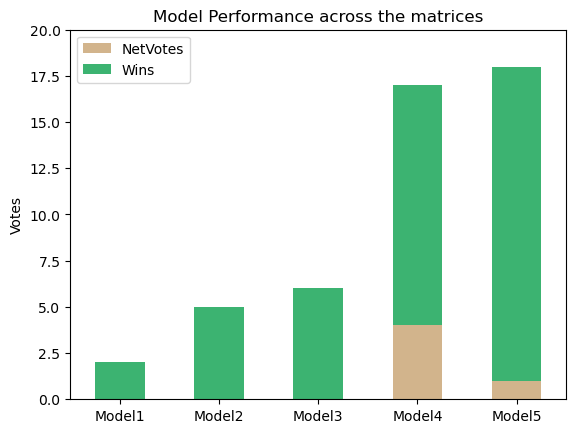

In [74]:
data = data[['NetVotes', 'Wins']].sort_values('Wins')
data.plot(kind='bar', stacked=True, color=['tan', 'mediumseagreen'])

plt.ylabel('Votes')
plt.xticks(rotation=0, ha='center')
plt.title('Model Performance across the matrices')
plt.ylim(0, 20)

plt.show()

## Testing the candidate models

In [75]:
# Creating a replacement dict to replace the name of the functions, by the functions, to be able to input their paramaters in GA()
rep_dict = {'ranking_selection': ranking_selection, 'roulette_wheel':roulette_wheel, 'tournament_sec2':tournament_selection(2),
            'tournament_sec5':tournament_selection(5), 'tournament_sec10':tournament_selection(10), 'two_point_xover':two_point_xover,
            'ox':ordered_xover, 'pmx_xover':pmx_xover, 'cyclic_xover':cyclic_xover, 'mm':mix_mutation,
            'swap_mutation':swap_mutation, 'inversion_mutation':inversion_mutation, 'dm':disp_mutation, 'tpm':two_point_mutation}

In [76]:
# Creating a copy of our df with the function instead of their names
df_funcs = df.copy()
new_index = df_funcs.index.map(lambda x: tuple(rep_dict.get(item, item) for item in x))
df_funcs.index = new_index
df_funcs

,,,,,,,,,Matrix1,Matrix2,Matrix3,Matrix4,Matrix5,Matrix6,Matrix7,Matrix8,Matrix9,Matrix10,Matrix11,Matrix12,Matrix13,Matrix14,Matrix15,Matrix16,Matrix17,Matrix18,Votes,Wins
Selector,Crossover,Mutator,Pop_Size,N_Gens,P_XO,P_M,Elitism,N_elites,,,,,,,,,,,,,,,,,,,,
<function tournament_selection.<locals>.tournament_sec at 0x0000024BABF8FCE0>,<function pmx_xover at 0x0000024BA947BE20>,<function inversion_mutation at 0x0000024BA8366700>,50,750,0.4,0.2,False,3,None,None,None,763.0,None,None,None,46869.0,None,None,None,None,None,None,None,None,None,None,2,2
<function tournament_selection.<locals>.tournament_sec at 0x0000024BABF8F100>,<function two_point_xover at 0x0000024BA947BD80>,<function swap_mutation at 0x0000024BA947BA60>,25,500,0.8,0.2,False,3,None,None,None,None,None,7369.0,None,None,None,62929.0,None,None,None,5076198.0,None,None,52552794.0,73352515.0,5,5
<function tournament_selection.<locals>.tournament_sec at 0x0000024BABF8FCE0>,<function two_point_xover at 0x0000024BA947BD80>,<function swap_mutation at 0x0000024BA947BA60>,50,750,0.4,0.2,False,3,None,None,None,763.0,5783.0,7369.0,None,None,None,None,None,725468.0,731619.0,5076198.0,None,None,None,None,6,6
<function tournament_selection.<locals>.tournament_sec at 0x0000024BABF8F100>,<function pmx_xover at 0x0000024BA947BE20>,<function inversion_mutation at 0x0000024BA8366700>,50,500,0.4,0.4,False,5,87.0,533.0,None,761.0,5766.67,7369.0,7959.0,46856.0,72044.0,62929.0,516715.0,725468.0,731619.0,5076198.0,7280064.0,7344888.0,52302596.0,73352515.0,17,13
<function ranking_selection at 0x0000024BA8366340>,<function cyclic_xover at 0x0000024BA947BB00>,<function inversion_mutation at 0x0000024BA8366700>,100,500,0.8,0.4,False,3,87.0,533.0,763.0,762.2,5783.0,7369.0,7959.0,46869.0,72044.0,62919.0,516715.0,725468.0,731619.0,5076198.0,7280064.0,7344888.0,52552794.0,73352515.0,18,17


Testing our pre-chosen models to every matrix:

In [30]:
results_geral = {}
# Iterating over every matrix
for i, mat in zip(trange(18), matrix):
    results_mat = []
    # And over every combination on best_models
    for func_index, str_index in zip(df_funcs.index, df.index):
        selector_func = func_index[0]
        crossover_func = func_index[1]
        mutator_func = func_index[2]

        selector = str_index[0]
        crossover = str_index[1]
        mutator = str_index[2]

        pop_size = str_index[3]
        n_gens = str_index[4]
        p_xo = str_index[5]
        p_m = str_index[6]
        elitism = str_index[7]
        n_elites = str_index[8]

        params = [selector, crossover, mutator,
                  pop_size, n_gens, p_xo, p_m, elitism, n_elites]
        score_list = []
        # Testring every model 5 times, and taking the mean of their scores
        for _ in range(5):

            score = GA(mat, create_population, evaluate_pop, selector_func, crossover_func, mutator_func, get_n_elites(n_elites), pop_size,
                       n_gens, p_xo, p_m, elitism=elitism)

            score_list.append(max(score[1]))

        final_score = round(np.mean(score_list), 3)

        results_mat.append([params, final_score])

    results_geral[f'Matrix{i+1}'] = results_mat

 11%|█         | 2/18 [04:53<39:07, 146.69s/it]


KeyboardInterrupt: 

In [77]:
# The results of our candidate models across the matrices, so you don't have to run it
results_geral = {'Matrix1': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   77.4],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   58.6],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   85.6],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   60.2],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   73.6]],
 'Matrix2': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   488.2],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   445.6],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   518.2],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   409.8],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   489.8]],
 'Matrix3': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   702.8],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   638.4],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   746.0],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   686.0],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   741.6]],
 'Matrix4': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   745.8],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   576.4],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   733.8],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   445.4],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   750.4]],
 'Matrix5': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   5456.0],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   4253.2],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   5339.8],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   4176.2],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   4810.2]],
 'Matrix6': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   6923.8],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   6548.8],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   7059.2],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   6165.6],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   7116.4]],
 'Matrix7': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   7495.0],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   5538.8],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   7567.0],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   3549.4],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   7007.8]],
 'Matrix8': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   44346.4],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   38846.8],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   46432.6],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   39301.6],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   44085.2]],
 'Matrix9': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   65118.0],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   59435.8],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   68505.8],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   54220.0],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   67026.6]],
 'Matrix10': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   54832.8],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   44581.6],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   60913.0],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   40822.6],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   54329.6]],
 'Matrix11': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   479674.8],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   401506.6],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   510678.2],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   403128.6],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   504012.4]],
 'Matrix12': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   697742.2],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   629129.8],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   695839.0],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   587919.4],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   703757.8]],
 'Matrix13': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   635034.4],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   478391.2],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   686732.8],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   428062.2],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   637607.2]],
 'Matrix14': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   4775459.8],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   4117705.6],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   4928387.4],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   3986815.2],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   4858322.4]],
 'Matrix15': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   6864879.4],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   5911232.0],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   7195034.8],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   6627719.4],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   7093473.6]],
 'Matrix16': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   6189421.6],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   4173697.0],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   7344888.0],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   3937254.6],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   6717785.2]],
 'Matrix17': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   50394243.8],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   43816079.4],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   51392290.0],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   43770182.4],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   50643960.0]],
 'Matrix18': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   69402902.8],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   58689493.0],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   68240519.6],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   54787677.4],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   68956928.4]]}

Transforming our results into a dataframe:

In [78]:
unique_param_combinations = set()
for mat in results_geral.values():
    for parameters, _ in mat:
        param_tuple = tuple(parameters)
        unique_param_combinations.add(tuple(param_tuple))

# creating the multiindex of our dataframe
index = pd.MultiIndex.from_tuples(unique_param_combinations, names=['Selector', 'Crossover', 'Mutator', 'Pop_Size', 'N_Gens', 'P_XO', 'P_M', 'Elitism', 'N_elites'])

scores = pd.DataFrame(index=index, columns=df.drop(['Votes', 'Wins'], axis=1).columns)

# iterating over the results
for matrix_name, mat in results_geral.items():
    for parameters, fitness in mat:
        param_tuple = tuple(parameters)
        scores.at[param_tuple, matrix_name] = fitness

scores

,,,,,,,,,Matrix1,Matrix2,Matrix3,Matrix4,Matrix5,Matrix6,Matrix7,Matrix8,Matrix9,Matrix10,Matrix11,Matrix12,Matrix13,Matrix14,Matrix15,Matrix16,Matrix17,Matrix18
Selector,Crossover,Mutator,Pop_Size,N_Gens,P_XO,P_M,Elitism,N_elites,,,,,,,,,,,,,,,,,,
tournament_sec5,pmx_xover,inversion_mutation,50,750,0.4,0.2,False,3,73.6,489.8,741.6,750.4,4810.2,7116.4,7007.8,44085.2,67026.6,54329.6,504012.4,703757.8,637607.2,4858322.4,7093473.6,6717785.2,50643960.0,68956928.4
tournament_sec10,two_point_xover,swap_mutation,25,500,0.8,0.2,False,3,85.6,518.2,746.0,733.8,5339.8,7059.2,7567.0,46432.6,68505.8,60913.0,510678.2,695839.0,686732.8,4928387.4,7195034.8,7344888.0,51392290.0,68240519.6
tournament_sec5,two_point_xover,swap_mutation,50,750,0.4,0.2,False,3,77.4,488.2,702.8,745.8,5456.0,6923.8,7495.0,44346.4,65118.0,54832.8,479674.8,697742.2,635034.4,4775459.8,6864879.4,6189421.6,50394243.8,69402902.8
tournament_sec10,pmx_xover,inversion_mutation,50,500,0.4,0.4,False,5,58.6,445.6,638.4,576.4,4253.2,6548.8,5538.8,38846.8,59435.8,44581.6,401506.6,629129.8,478391.2,4117705.6,5911232.0,4173697.0,43816079.4,58689493.0
ranking_selection,cyclic_xover,inversion_mutation,100,500,0.8,0.4,False,3,60.2,409.8,686.0,445.4,4176.2,6165.6,3549.4,39301.6,54220.0,40822.6,403128.6,587919.4,428062.2,3986815.2,6627719.4,3937254.6,43770182.4,54787677.4


Getting the wins column:

In [79]:
max_indices = pd.DataFrame(index=scores.columns, columns=['Max_Indices'])

# Iterate over each column
for column in scores.columns:
    # Find the maximum value in the column
    max_val = scores[column].max()
    # Find all indices where the maximum value occurs
    indices = scores[scores[column] == max_val].index.tolist()
    # Store the indices in the 'Max_Indices' column
    max_indices.at[column, 'Max_Indices'] = indices

winners = dict(max_indices.explode('Max_Indices').value_counts())
winners = {key[0]:val for key, val in winners.items()}
scores['Wins'] = winners
scores['Wins'].fillna(0, inplace=True)
scores.loc[:,scores.columns.isin(['Wins'])]

,,,,,,,,,Wins
Selector,Crossover,Mutator,Pop_Size,N_Gens,P_XO,P_M,Elitism,N_elites,
tournament_sec5,pmx_xover,inversion_mutation,50,750,0.4,0.2,False,3,3.0
tournament_sec10,two_point_xover,swap_mutation,25,500,0.8,0.2,False,3,13.0
tournament_sec5,two_point_xover,swap_mutation,50,750,0.4,0.2,False,3,2.0
tournament_sec10,pmx_xover,inversion_mutation,50,500,0.4,0.4,False,5,0.0
ranking_selection,cyclic_xover,inversion_mutation,100,500,0.8,0.4,False,3,0.0


Text(0.5, 1.0, 'Number of wins across the 18 matrices of each model')

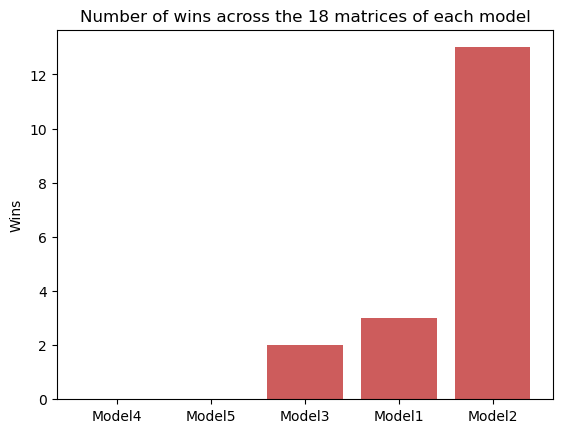

In [81]:
data = scores['Wins'].sort_values(ascending=True)
data.index = [ model_labels[data.index[i]] for i in range(len(data)) ]
plt.bar(data.index, data, color='indianred')
plt.ylabel('Wins')
plt.title('Number of wins across the 18 matrices of each model')

Creating other performance measures (ranking, mean and median)

In [82]:
scores_ranked = scores.rank()
scores_ranked['Mean'] = scores_ranked.mean(axis=1)
scores_ranked['Median'] = scores_ranked.median(axis=1)
scores_ranked.loc[:,scores_ranked.columns.isin(['Wins', 'Mean', 'Median'])].sort_values('Wins', ascending=False)

Wins  \
Selector          Crossover       Mutator            Pop_Size N_Gens P_XO P_M Elitism N_elites         
tournament_sec10  two_point_xover swap_mutation      25       500    0.8  0.2 False   3          5.0   
tournament_sec5   pmx_xover       inversion_mutation 50       750    0.4  0.2 False   3          4.0   
                  two_point_xover swap_mutation      50       750    0.4  0.2 False   3          3.0   
tournament_sec10  pmx_xover       inversion_mutation 50       500    0.4  0.4 False   5          1.5   
ranking_selection cyclic_xover    inversion_mutation 100      500    0.8  0.4 False   3          1.5   

                                                                                                    Mean  \
Selector          Crossover       Mutator            Pop_Size N_Gens P_XO P_M Elitism N_elites             
tournament_sec10  two_point_xover swap_mutation      25       500    0.8  0.2 False   3         4.578947   
tournament_sec5   pmx_xover       inversion_mutation 50       750    0.4  0.2 False   3         3.894737   
                  two_point_xover swap_mutation      50       750    0.4  0.2 False   3         3.526316   
tournament_sec10  pmx_xover       inversion_mutation 50       500    0.4  0.4 False   5         1.710526   
ranking_selection cyclic_xover    inversion_mutation 100      500    0.8  0.4 False   3         1.289474   

                                                                                                Median  
Selector          Crossover       Mutator            Pop_Size N_Gens P_XO P_M Elitism N_elites          
tournament_sec10  two_point_xover swap_mutation      25       500    0.8  0.2 False   3            5.0  
tournament_sec5   pmx_xover       inversion_mutation 50       750    0.4  0.2 False   3            4.0  
                  two_point_xover swap_mutation      50       750    0.4  0.2 False   3            3.0  
tournament_sec10  pmx_xover       inversion_mutation 50       500    0.4  0.4 False   5            2.0  
ranking_selection cyclic_xover    inversion_mutation 100      500    0.8  0.4 False   3            1.0

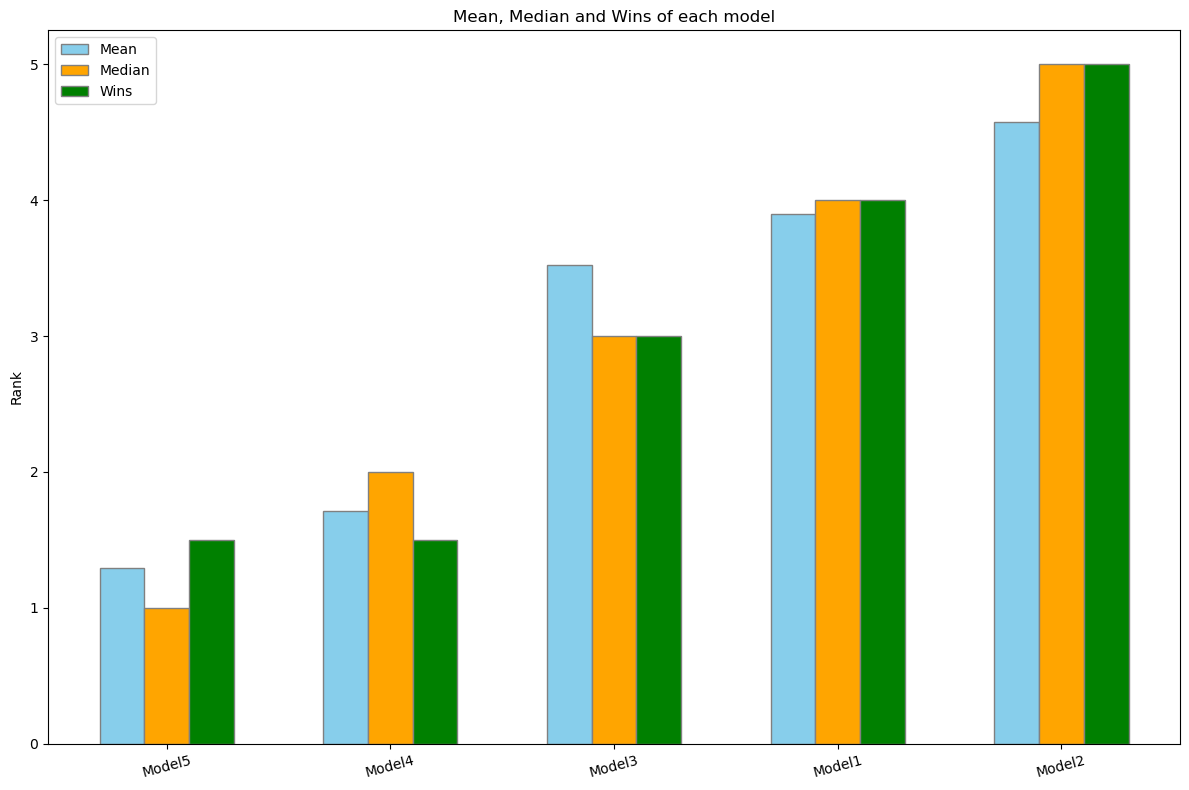

In [83]:
sorted_df = scores_ranked.sort_values(['Wins', 'Median', 'Mean'], ascending=True)
sorted_df.index = [ model_labels[sorted_df.index[i]] for i in range(len(sorted_df)) ]
labels = sorted_df.index
means = list(sorted_df['Mean'])
medians = list(sorted_df['Median'])
wins = list(sorted_df['Wins'])

bar_width = 0.2

r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(12, 8))

plt.bar(r1, means, color='skyblue', width=bar_width, edgecolor='grey', label='Mean')
plt.bar(r2, medians, color='orange', width=bar_width, edgecolor='grey', label='Median')
plt.bar(r3, wins, color='green', width=bar_width, edgecolor='grey', label='Wins')

plt.ylabel('Rank')
plt.title('Mean, Median and Wins of each model')
plt.xticks([r + bar_width for r in range(len(labels))], labels, rotation=15, ha='center')
plt.legend()
plt.tight_layout()

plt.show()

In [37]:
best_model = [key for key, val in model_labels.items() if val == 'Model5'][0]
best_model

('ranking_selection',
 'cyclic_xover',
 'inversion_mutation',
 100,
 500,
 0.8,
 0.4,
 False,
 3)